# Introduction

COVID has impacted our daily life since December 2019. It has an "appropriate" spread rate and death rate, so it immediately spreads worldwide and damages society and the economy a lot.

And there is a small community with approximately 1000 people. One day, the local government suddenly found that there were $I0 = 5$ people showing symptoms of COVID. To reduce the effect of COVID on this small community, the government has several strategies to stop the spread of COVID, but they do not know which one is the best. 

Therefore, in this project, we will figure out which strategy is the best for this small community, and advise the small community to use this strategy to stop the COVID, and give an approximate number of people being affected in this epidemic.

To figure out which strategy is the best, we first model the spread of COVID without any intervene, to see what will happen if we do not take any approach. Instead of using stochastic or traditional SIR model, we model the spread of COVID in a network model, for example the small-world or BA model. And by using these network model, we can better imitate the spread of COVID in the real world.

After that, it is not enough to play the model, so that we will compare our model to a small community in the real world. In this project, we choose Aosta, Italy, a small city with only about 34,000 people [1], to see how our model fits the actual data.

Finally, we will model several strategies and determine which one gives the best result, for example, the minimum number of infected people, and share our advice.

# Part I: Model the Spread of COVID without Intervere

In [16]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import pylab
from tqdm import tqdm

"tqdm" package is a package that gives out a progress bar during the for loop. If you do not have the "tqdm" package, you can use pip to download it. Or just delete every tqdm in front of the for loop's range().

For example:

Before: for nn_model in tqdm(range(num_loop)):

After: for nn_model in range(num_loop):

In this part, we are trying to model the spread of COVID in a small community without any interfere, and we devide people into 5 categories: S, I, R, I1, I2, V.

I1 is the number of people who get infected within 24h, without symptoms, but can spread disease.

I2 is the number of people infected between 24h - 48h, without symptoms, but can spread disease.

V is the number of people who get vaccinated, and we will not use it in part I.

We assume that the total number of people in this community is $N = 1000$, and we begin with $I0 = 5$ people being infected.

According to the research (Reference), the average number of people one person close contact with every day is $contact\_num = 13$ [2], and the rate of being infected during the close contact is $a = 0.026$ [3].

Also, those who recovered from COVID have $Re\_S = 0.2$ probability of becoming S again [4].

In [17]:
# Total population, N.
N = 1000
I0 = 5
R0 = 0
S0 = N - I0 - R0
I10 = 0
I20 = 0
V0 = 0


a = 0.026
b = 0.1
contact_num = 13
Re_S = 0.2

And we model the spread in $T = 200$ days, with time slot $dt = 1$ day.

In [18]:
# A grid of time points (in days)
T = 200
dt = 1
Nt = int(T/dt) + 1
t = np.linspace(0, T, Nt)

The following three functions are helper functions.

In [19]:
# Transform the networkx format to a matrix, which will be easier to calculate.
def networkx_to_matrix(G):
    G_num_node = G.number_of_nodes()
    G_to_matrix = np.zeros((G_num_node, G_num_node))
    edges_list = list(G.edges())
    for i in edges_list:
        G_to_matrix[i[0], i[1]] = 1
        G_to_matrix[i[1], i[0]] = 1
    return G_to_matrix

In [20]:
# Init the initial station of each node.
def SIR_init(G, I_indices, I2_indices = []):
    if(type(G) == np.ndarray):
        G_num_node = G.shape[0]
    elif(type(G) == nx.classes.graph.Graph):
        G_num_node = G.number_of_nodes()
    else:
        print("Type of the first input can only be graph or graph matrix.")
        assert(0)
    SIR_node = np.zeros(G_num_node)
    SIR_node[I_indices] = 3
    SIR_node[I2_indices] = 2
    return SIR_node

In [21]:
# SIR step.
def SIRstep(G_network, SIR_node, S, I, R, a, b, dt, skip_rate = 0):
    if(type(G_network) == nx.classes.graph.Graph):
        G_network = networkx_to_matrix(G_network)
    elif(type(G_network) != np.ndarray):
        print("Type of the first input can only be graph or graph matrix.")
        assert(0)

    N = S + I + R
    I_list = np.where((SIR_node == 1) | (SIR_node == 3) | (SIR_node == 4))[0]
    I_list_tmp = I_list
    S_list = np.where((SIR_node == 0) | (SIR_node == 5))[0]

    # Change the state of infected people
    for i in I_list:
        if(SIR_node[i] == 3):
            SIR_node[i] = 4
        elif(SIR_node[i] == 4):
            SIR_node[i] = 1

    # Spread
    for i in S_list:
        if (I_list_tmp.size > 0) and (i == I_list_tmp[0]):
            np.delete(I_list_tmp, 0)
            continue
        for j in I_list_tmp:
            if(G_network[i, j] == 1) & (np.random.random_sample() < (1 - skip_rate)):
                if (SIR_node[i] == 0) and (np.random.random_sample() < a * dt):
                    S, I = S-1, I+1
                    SIR_node[i] = 3
                elif (SIR_node[i] == 5) and (np.random.random_sample() < a * (1 - eff) * dt):
                    S, I = S-1, I+1
                    SIR_node[i] = 3

    # Recover
    for i in I_list:
        if (np.random.random_sample() < b*dt):
            if (np.random.random_sample() < Re_S):
                I, S = I-1, S+1
                SIR_node[i] = 0
            else:
                I, R = I-1, R+1
                SIR_node[i] = 2
            
    return S, I, R

## Generate Network Models

The following two blocks generate two network models: the Small-world model and Barabási–Albert (BA) model.

### Small-World Model
In real-world interactions, many individuals have a limited and, often at least, a fixed number of connections. \[5\]

Therefore, the small-world model assumes that people have the same number of neighbors, and also, they may connect to not neighbored people. So we also need to introduce a reconnection probability, which is $p\_rewire = 0.05$ --- the probability that one node drops the edge with its neighbor and connects to a node that is not its neighbor.

<img style="float:center;" src="./Small_world.png" width = "50%">

The small-world model is not a scale-free model. Still, since we need to imitate the spread of disease in a confined community, people are more likely to contact the people near to them, especially when the community is super large. But this model may have the problem that it does not consider the case of superspreader. [5]

In [22]:
# Generate Small-World Model
p_rewire = 0.05
G_SW = nx.generators.random_graphs.watts_strogatz_graph(N, contact_num, p_rewire)
G_SW_matrix = networkx_to_matrix(G_SW)
SIR_SW = np.zeros(N)
print("This small-world model have", G_SW.number_of_edges(), "edges.")

This small-world model have 6000 edges.


### Barabási–Albert (BA) Model

Many networks are highly right-skewed, most vertices have only a low degree, but there is a small number whose degree is very high.[5]

BA-model is a scale-free model built from a small group of people and gradually adds new people to this group. And the new coming people are more likely to connect to the persons with a large degree.

So sometimes BA model can better imitate the real world since it also considers the case of superspreader. But if the community is large enough, people can hardly contact those far from them; even they are very famous. So, the BA model can better estimate the connection in a small community like in this case.

In [23]:
# Generate BA Model
edge_of_new = contact_num // 2
G_BA = nx.generators.random_graphs.barabasi_albert_graph(N, edge_of_new)
G_BA_matrix = networkx_to_matrix(G_BA)
SIR_BA = np.zeros(N)
print("This BA model have", G_BA.number_of_edges(), "edges.")

This BA model have 5964 edges.


## Spread of COVID

Begin to model the spread of COVID.

In [24]:
# Randomly choose I0 people infected to begin with.
# S = 0, I = 1, R = 2
indices = random.sample(list(range(N)), I0 - 1)
indices = indices + [1]
print(indices)

[797, 126, 955, 146, 1]


In [25]:
# Solve Small-world Model
num_loop = 6
X_SW_all = np.zeros((num_loop, Nt, 3))
worse = 0
worse_num = N
for nn_model in tqdm(range(num_loop)):
    Ss_SW, Is_SW, Rs_SW = S0, I0, R0
    X_SW0 = [[Ss_SW, Is_SW, Rs_SW]]

    SIR_SW = SIR_init(G_SW_matrix, indices)
    for i in range(Nt - 1):
        Ss_SW, Is_SW, Rs_SW = SIRstep(G_SW_matrix, SIR_SW, Ss_SW, Is_SW, Rs_SW, a, b, dt)
        X_SW0 = X_SW0 + [[Ss_SW, Is_SW, Rs_SW]]   # Append to list

    X_SW_all[nn_model] = np.asarray(X_SW0)
    final_one = np.asarray(X_SW0)[Nt - 1, 0]

    if(worse_num > final_one):
        worse_num = final_one
        worse = nn_model

X_SW = X_SW_all[worse]

100%|██████████| 6/6 [01:05<00:00, 10.96s/it]


In [26]:
# Solve BA Model
num_loop = 6
X_BA_all = np.zeros((num_loop, Nt, 3))
worse = 0
worse_num = N
for nn_model in tqdm(range(num_loop)):
    Ss_BA, Is_BA, Rs_BA = S0, I0, R0
    X_BA0 = [[Ss_BA, Is_BA, Rs_BA]]

    SIR_BA = SIR_init(G_BA_matrix, indices)
    for i in range(Nt - 1):
        Ss_BA, Is_BA, Rs_BA = SIRstep(G_BA_matrix, SIR_BA, Ss_BA, Is_BA, Rs_BA, a, b, dt)
        X_BA0 = X_BA0 + [[Ss_BA, Is_BA, Rs_BA]]   # Append to list

    X_BA_all[nn_model] = np.asarray(X_BA0)
    final_one = np.asarray(X_BA0)[Nt - 1, 0]

    if(worse_num > final_one):
        worse_num = final_one
        worse = nn_model
X_BA = X_BA_all[worse]

100%|██████████| 6/6 [00:47<00:00,  7.94s/it]


In [27]:
# Store the models and solutions
Model_graph_list = [G_SW_matrix, G_BA_matrix]
num_model = len(Model_graph_list)
Ss = np.zeros((num_model, T + 1))
Is = np.zeros((num_model, T + 1))
Rs = np.zeros((num_model, T + 1))

Ss[0] = X_SW[:, 0]
Is[0] = X_SW[:, 1]
Rs[0] = X_SW[:, 2]

Ss[1] = X_BA[:, 0]
Is[1] = X_BA[:, 1]
Rs[1] = X_BA[:, 2]

Plot the change of SIR.

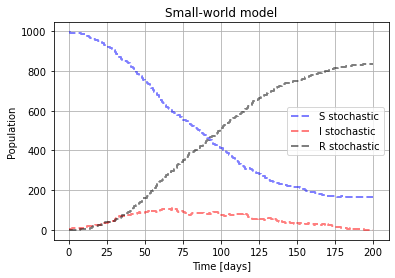

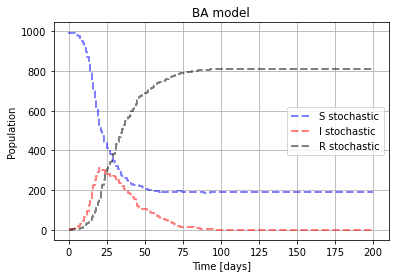

In [28]:
# Plot deterministic and stochastic results in same figure
# i_th_model = 0: Small-world model
# i_th_model = 1: BA model
i_th_model = 0

fig = plt.figure(facecolor='w')
plt.step(t, Ss[i_th_model], 'b--',  alpha=0.5, lw=2, label='S stochastic')
plt.step(t, Is[i_th_model], 'r--',  alpha=0.5, lw=2, label='I stochastic')
plt.step(t, Rs[i_th_model], 'k--',  alpha=0.5, lw=2, label='R stochastic')
plt.xlabel('Time [days]')
plt.ylabel('Population')
plt.title('Small-world model')
plt.grid()
plt.legend()


i_th_model = 1

fig = plt.figure(facecolor='w')
plt.step(t, Ss[i_th_model], 'b--',  alpha=0.5, lw=2, label='S stochastic')
plt.step(t, Is[i_th_model], 'r--',  alpha=0.5, lw=2, label='I stochastic')
plt.step(t, Rs[i_th_model], 'k--',  alpha=0.5, lw=2, label='R stochastic')
plt.xlabel('Time [days]')
plt.ylabel('Population')
plt.title('BA model')
plt.grid()
plt.legend()

This is also a helper function, which is used to plot the network graph.

In [29]:
def graph_plot(graph, indices1, indices2 = []):
    Ss_model, Is_model, Rs_model = S0, I0, R0
    X_model = [[Ss_model, Is_model, Rs_model]]

    SIR_model = SIR_init(graph, indices1, indices2)
    graph_time = 20
    total_graph = Nt // graph_time + 1
    rows = (total_graph - 1) // 2 + 1
    flag = 1

    num_graph = 2


    plt.figure(num=None, figsize=(40, 20 * rows), dpi=160)

    color_map = []
    for i in range(N):
        if((SIR_model[i] == 0) | (SIR_model[i] == 5)):
            color_map.append('green')
        elif((SIR_model[i] == 1) | (SIR_model[i] == 3) | (SIR_model[i] == 4)):
            color_map.append('red')
        else:
            color_map.append('gray')

    ax0 = plt.subplot(rows, 2, 1)      
    ax0.title.set_text("t = 0")
    pos = nx.spring_layout(graph)

    nx.draw_networkx_nodes(graph, pos, node_color = color_map)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)


    for i in tqdm(range(1, Nt)):
        Ss_model, Is_model, Rs_model = SIRstep(graph, SIR_model, Ss_model, Is_model, Rs_model, a, b, dt)
        X_model = X_model + [[Ss_model, Is_model, Rs_model]]   # Append to list

        if(i % graph_time == 0) & (flag != 0):
            if(Is_model == 0):
                flag = 0

            color_map = []
            for i in range(N):
                if((SIR_model[i] == 0) | (SIR_model[i] == 5)):
                    color_map.append('green')   
                elif((SIR_model[i] == 1) | (SIR_model[i] == 3) | (SIR_model[i] == 4)):
                    color_map.append('red')
                else:
                    color_map.append('gray')

            ax = plt.subplot(rows, 2, num_graph)     
            ax.title.set_text("t = {}".format((num_graph - 1) * graph_time))
            pos = nx.spring_layout(graph)

            nx.draw_networkx_nodes(graph, pos, node_color = color_map)
            nx.draw_networkx_edges(graph,pos)
            nx.draw_networkx_labels(graph,pos)
            num_graph += 1

    plt.show()

Plot the network graph.

In [30]:
# It will take about 70s to draw the plot.
graph_plot(G_SW, indices1=indices)

In [33]:
# It will take about 60s to draw the plot.
graph_plot(G_BA, indices1=indices)

According to the graph, the disease has infected almost everyone in the center (people with large degrees). And most of the green points (healthy people) are located outside the center (people with small degrees), which coincides with our suppose.

# Part II: Compare the Model with Data in Aosta, Italy

In [34]:
# Store the models and solutions
methods_N = 7
Model_graph_list = [G_SW_matrix, G_BA_matrix]
num_model = len(Model_graph_list)
Ss_all = np.zeros((methods_N, num_model, T + 1))
Is_all = np.zeros((methods_N, num_model, T + 1))
Rs_all = np.zeros((methods_N, num_model, T + 1))

Ss_all[0] = Ss
Is_all[0] = Is
Rs_all[0] = Rs

Aosta is a small city with about 34,300 population in Italy. Since it is small enough that everyone is close enough to contact anyone in this city, it can apply the BA model to this city.

Since the first outbreak of COVID in this city was around October, people have already noticed that it is not a common disease, and people choose to cut down the frequency to go out. So the original model, which models the spread of COVID without intervening, may not be suitable for this data.

So, we introduce our first intervention strategy, lockdown, and try to model the spread of COVID under lockdown to fit the data in Aosta.

## Lockdown

When a lockdown is applied, we suppose the daily contact between people will go down $skip\_rate = 78\%$.

In [35]:
skip_rate = 0.78

In [36]:
# Solve Small-world Model
num_loop = 6
X_SW_all = np.zeros((num_loop, Nt, 3))
worse = 0
worse_num = N
for nn_model in tqdm(range(num_loop)):
    Ss_SW, Is_SW, Rs_SW = S0, I0, R0
    X_SW0 = [[Ss_SW, Is_SW, Rs_SW]]

    SIR_SW = SIR_init(G_SW_matrix, indices)
    for i in range(Nt - 1):
        Ss_SW, Is_SW, Rs_SW = SIRstep(G_SW_matrix, SIR_SW, Ss_SW, Is_SW, Rs_SW, a, b, dt, skip_rate)
        X_SW0 = X_SW0 + [[Ss_SW, Is_SW, Rs_SW]]   # Append to list
    X_SW_all[nn_model] = np.asarray(X_SW0)
    final_one = np.asarray(X_SW0)[Nt - 1, 0]
    
    if(worse_num > final_one):
        worse_num = final_one
        worse = nn_model
X_SW = X_SW_all[worse]

100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


In [37]:
# Solve BA Model
num_loop = 12
X_BA_all = np.zeros((num_loop, Nt, 3))
worse = 0
worse_num = N
for nn_model in tqdm(range(num_loop)):
    Ss_BA, Is_BA, Rs_BA = S0, I0, R0
    X_BA0 = [[Ss_BA, Is_BA, Rs_BA]]

    SIR_BA = SIR_init(G_BA_matrix, indices)
    for i in range(Nt - 1):
        Ss_BA, Is_BA, Rs_BA = SIRstep(G_BA_matrix, SIR_BA, Ss_BA, Is_BA, Rs_BA, a, b, dt, skip_rate)
        X_BA0 = X_BA0 + [[Ss_BA, Is_BA, Rs_BA]]   # Append to list
    X_BA_all[nn_model] = np.asarray(X_BA0)
    final_one = np.asarray(X_BA0)[Nt - 1, 0]
        
    if(worse_num > final_one):
        worse_num = final_one
        worse = nn_model
X_BA = X_BA_all[worse]

100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


In [38]:
# Store the value
Ss_all[1, 0] = X_SW[:, 0]
Is_all[1, 0] = X_SW[:, 1]
Rs_all[1, 0] = X_SW[:, 2]

Ss_all[1, 1] = X_BA[:, 0]
Is_all[1, 1] = X_BA[:, 1]
Rs_all[1, 1] = X_BA[:, 2]

The following cell stores the data in Aosta, Italy.

The total population in this city is 34,000, and we store the data from September 1st, 2020.

In [40]:
N_Aosta = 34000
I_Aosta = np.zeros(173)
I_Aosta[0] = 0
i = 0
f = open("Aosta_Italy.txt", "r")
for i in range(1, 173):
    line = f.readline()
    if(line == ''):
        break
    I_Aosta[i] = I_Aosta[i - 1] + int(line)

Since my computer cannot support calculating a network with 30,000+ nodes, we scale the data of the toy BA model and compare it with the data in Aosta, Italy.

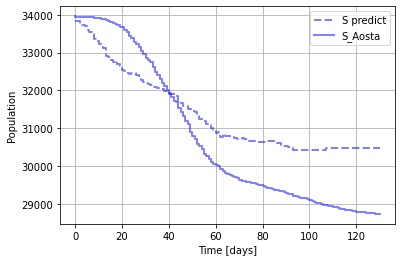

In [41]:
i_th_model = 1
fig = plt.figure(facecolor='w')
t_131 = np.linspace(0, 130, 131)
Ss_scale = Ss_all[1, i_th_model] * N_Aosta / N
Is_scale = Is_all[1, i_th_model] * N_Aosta / N

Ss_Aosta = N_Aosta * np.ones(131)
Is_Aosta = I_Aosta[25 : 25 + 130 + 1]
Ss_Aosta = Ss_Aosta - (1 - Re_S) * Is_Aosta

plt.step(t_131, Ss_scale[0 : 131], 'b--',  alpha=0.5, lw=2, label='S predict')
plt.step(t_131, Ss_Aosta, 'b',  alpha=0.5, lw=2, label='S_Aosta')

plt.xlabel('Time [days]')
plt.ylabel('Population')
plt.grid()
plt.legend()

When it starts appropriately, the BA model will fit the data in Aosta, Italy, pretty well for most cases. Since there is some randomness in this model, so if the plot looks not good, maybe you can run the cell from "Lockdown" again.

# Part III: Intervene

In this part, we are trying to lower the damage of this disease, that is, low down the number of infected people by COVID.

We have several ideas about how to control the disease, but we do not know which one will be best suited to this community. 

The first one is vaccination. Using this method, we give the vaccine to those healthy people every day, protecting them from getting COVID. 

And the second is locking down. We control to cut down the number of close contact in this community by shutting down bars, schools, and other social places. 

And the last one is to quarantine people who show symptoms, those who show symptoms are not allowed to contact anyone within ten days.

Therefore, in this part, we will find which method is the best for this community. And according to the research, we can guide the local government in this community can use this intervention method to stop the spread of COVID.

## Vaccination

Using this method, we suppose $Vac\_rate = 80\%$ of the people in this community will get the vaccine, and there will be $Vac\_daily = 20$ people get the vaccine each day.

The effectiveness of vaccine is $eff = 88\%$ (Pfizer against Delta variant).

We only give the vaccine to sensitive people, those who have already caught or recovered from the COVID will not be vaccinated. So maybe the vaccinated rate is lower than 80\%.

In [42]:
Vac_rate = 0.8
Vac_N = int(N * Vac_rate)
Vac_daily = 20
eff = 0.88

### Vaccinate random people every day

In this part, we randomly choose sensitive people to give the vaccine.

In [43]:
# Solve Small-world Model
num_loop = 6
X_SW_all = np.zeros((num_loop, Nt, 3))
worse = 0
worse_num = N
for nn_model in tqdm(range(num_loop)):
    Ss_SW, Is_SW, Rs_SW = S0, I0, R0
    X_SW0 = [[Ss_SW, Is_SW, Rs_SW]]
    Vac_already = 0

    SIR_SW = SIR_init(G_SW_matrix, indices)
    for i in range(Nt - 1):
        # Vaccine
        if(Vac_N > Vac_already):
            S_list = np.where(SIR_SW == 0)[0]
            if(len(list(S_list)) <= Vac_daily):
                Vac = list(S_list)
                Vac_already += len(list(S_list))
            else:
                Vac = random.sample(list(S_list), Vac_daily)
                Vac_already += 15
            Vac.sort()
            SIR_SW[Vac] = 5

        # Spread
        Ss_SW, Is_SW, Rs_SW = SIRstep(G_SW_matrix, SIR_SW, Ss_SW, Is_SW, Rs_SW, a, b, dt)
        X_SW0 = X_SW0 + [[Ss_SW, Is_SW, Rs_SW]]   # Append to list

    X_SW_all[nn_model] = np.asarray(X_SW0)
    final_one = np.asarray(X_SW0)[Nt - 1, 0]

    if(worse_num > final_one):
        worse_num = final_one
        worse = nn_model

X_SW = X_SW_all[worse]

100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


In [44]:
# Solve BA Model
num_loop = 6
X_BA_all = np.zeros((num_loop, Nt, 3))
worse = 0
worse_num = N
for nn_model in tqdm(range(num_loop)):
    Ss_BA, Is_BA, Rs_BA = S0, I0, R0
    X_BA0 = [[Ss_BA, Is_BA, Rs_BA]]
    Vac_already = 0

    SIR_BA = SIR_init(G_BA_matrix, indices)
    for i in range(Nt - 1):
        # Vaccine
        if(Vac_N > Vac_already):
            S_list = np.where(SIR_BA == 0)[0]
            if(len(list(S_list)) <= Vac_daily):
                Vac = list(S_list)
                Vac_already += len(list(S_list))
            else:
                Vac = random.sample(list(S_list), Vac_daily)
                Vac_already += 15
            Vac.sort()
            SIR_BA[Vac] = 5

        Ss_BA, Is_BA, Rs_BA = SIRstep(G_BA_matrix, SIR_BA, Ss_BA, Is_BA, Rs_BA, a, b, dt)
        X_BA0 = X_BA0 + [[Ss_BA, Is_BA, Rs_BA]]   # Append to list
    X_BA_all[nn_model] = np.asarray(X_BA0)
    final_one = np.asarray(X_BA0)[Nt - 1, 0]

    if(worse_num > final_one):
        worse_num = final_one
        worse = nn_model
X_BA = X_BA_all[worse]

100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


In [45]:
# Store the value
Ss_all[2, 0] = X_SW[:, 0]
Is_all[2, 0] = X_SW[:, 1]
Rs_all[2, 0] = X_SW[:, 2]

Ss_all[2, 1] = X_BA[:, 0]
Is_all[2, 1] = X_BA[:, 1]
Rs_all[2, 1] = X_BA[:, 2]

### Selectively Vaccine

In this part, we first give the vaccine to those with large degrees. And since these people are more likely to be infected, it is expected to be better than randomly giving the vaccine.

In [46]:
# Solve Small-world Model
num_loop = 6
X_SW_all = np.zeros((num_loop, Nt, 3))
worse = 0
worse_num = N
for nn_model in tqdm(range(num_loop)):
    Ss_SW, Is_SW, Rs_SW = S0, I0, R0
    X_SW0 = [[Ss_SW, Is_SW, Rs_SW]]
    Vac_already = 0
    point = 0
    degree = np.zeros(N)
    for i in range(N):
        degree[i] = G_SW.degree(i)
    degree_sorted = degree.argsort()[::-1]


    SIR_SW = SIR_init(G_SW_matrix, indices)
    for i in range(Nt - 1):
        # Vaccine
        Vac_today = 0
        S_list = np.where(SIR_SW == 0)[0]
        while((Vac_today < Vac_daily) & (point < N)):
            if degree_sorted[point] in S_list:
                SIR_SW[degree_sorted[point]] = 5
                Vac_already += 1
                Vac_today += 1
            point += 1    

        # Spread
        Ss_SW, Is_SW, Rs_SW = SIRstep(G_SW_matrix, SIR_SW, Ss_SW, Is_SW, Rs_SW, a, b, dt)
        X_SW0 = X_SW0 + [[Ss_SW, Is_SW, Rs_SW]]   # Append to list
    X_SW_all[nn_model] = np.asarray(X_SW0)
    final_one = np.asarray(X_SW0)[Nt - 1, 0]
    
    if(worse_num > final_one):
        worse_num = final_one
        worse = nn_model
X_SW = X_SW_all[worse]

100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


In [47]:
# Solve BA Model
num_loop = 6
X_BA_all = np.zeros((num_loop, Nt, 3))
worse = 0
worse_num = N
for nn_model in tqdm(range(num_loop)):
    Ss_BA, Is_BA, Rs_BA = S0, I0, R0
    X_BA0 = [[Ss_BA, Is_BA, Rs_BA]]
    Vac_already = 0
    point = 0
    degree = np.zeros(N)
    for i in range(N):
        degree[i] = G_SW.degree(i)
    degree_sorted = degree.argsort()[::-1]


    SIR_BA = SIR_init(G_BA_matrix, indices)
    for i in range(Nt - 1):
        # Vaccine
        Vac_today = 0
        S_list = np.where(SIR_BA == 0)[0]
        while((Vac_today < Vac_daily) & (point < N)):
            if degree_sorted[point] in S_list:
                SIR_BA[degree_sorted[point]] = 5
                Vac_already += 1
                Vac_today += 1
            point += 1 

        Ss_BA, Is_BA, Rs_BA = SIRstep(G_BA_matrix, SIR_BA, Ss_BA, Is_BA, Rs_BA, a, b, dt)
        X_BA0 = X_BA0 + [[Ss_BA, Is_BA, Rs_BA]]   # Append to list
    X_BA_all[nn_model] = np.asarray(X_BA0)
    final_one = np.asarray(X_BA0)[Nt - 1, 0]
    
    if(worse_num > final_one):
        worse_num = final_one
        worse = nn_model
X_BA = X_BA_all[worse]

100%|██████████| 6/6 [00:40<00:00,  6.75s/it]


In [48]:
# Store the value
Ss_all[3, 0] = X_SW[:, 0]
Is_all[3, 0] = X_SW[:, 1]
Rs_all[3, 0] = X_SW[:, 2]

Ss_all[3, 1] = X_BA[:, 0]
Is_all[3, 1] = X_BA[:, 1]
Rs_all[3, 1] = X_BA[:, 2]

## Random Vaccine and Lockdown

In this part, we combine the method of randomly giving the vaccine to people and the lockdown strategy. But now we low down the lockdown rate to 50\%.

In [49]:
Vac_rate = 0.8
Vac_N = int(N * Vac_rate)
Vac_daily = 25
eff = 0.88
skip_rate = 0.5

In [50]:
# Solve Small-world Model
num_loop = 6
X_SW_all = np.zeros((num_loop, Nt, 3))
worse = 0
worse_num = N
for nn_model in tqdm(range(num_loop)):
    Ss_SW, Is_SW, Rs_SW = S0, I0, R0
    X_SW0 = [[Ss_SW, Is_SW, Rs_SW]]
    Vac_already = 0

    SIR_SW = SIR_init(G_SW_matrix, indices)
    for i in range(Nt - 1):
        # Vaccine
        if(Vac_N > Vac_already):
            S_list = np.where(SIR_SW == 0)[0]
            if(len(list(S_list)) <= Vac_daily):
                Vac = list(S_list)
                Vac_already += len(list(S_list))
            else:
                Vac = random.sample(list(S_list), Vac_daily)
                Vac_already += 15
            Vac.sort()
            SIR_SW[Vac] = 5

        # Spread
        Ss_SW, Is_SW, Rs_SW = SIRstep(G_SW_matrix, SIR_SW, Ss_SW, Is_SW, Rs_SW, a, b, dt, skip_rate)
        X_SW0 = X_SW0 + [[Ss_SW, Is_SW, Rs_SW]]   # Append to list

    X_SW_all[nn_model] = np.asarray(X_SW0)
    final_one = np.asarray(X_SW0)[Nt - 1, 0]

    if(worse_num > final_one):
        worse_num = final_one
        worse = nn_model

X_SW = X_SW_all[worse]

100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


In [51]:
# Solve BA Model
num_loop = 6
X_BA_all = np.zeros((num_loop, Nt, 3))
worse = 0
worse_num = N
for nn_model in tqdm(range(num_loop)):
    Ss_BA, Is_BA, Rs_BA = S0, I0, R0
    X_BA0 = [[Ss_BA, Is_BA, Rs_BA]]
    Vac_already = 0

    SIR_BA = SIR_init(G_BA_matrix, indices)
    for i in range(Nt - 1):
        # Vaccine
        if(Vac_N > Vac_already):
            S_list = np.where(SIR_BA == 0)[0]
            if(len(list(S_list)) <= Vac_daily):
                Vac = list(S_list)
                Vac_already += len(list(S_list))
            else:
                Vac = random.sample(list(S_list), Vac_daily)
                Vac_already += 15
            Vac.sort()
            SIR_BA[Vac] = 5

        Ss_BA, Is_BA, Rs_BA = SIRstep(G_BA_matrix, SIR_BA, Ss_BA, Is_BA, Rs_BA, a, b, dt, skip_rate)
        X_BA0 = X_BA0 + [[Ss_BA, Is_BA, Rs_BA]]   # Append to list
    X_BA_all[nn_model] = np.asarray(X_BA0)
    final_one = np.asarray(X_BA0)[Nt - 1, 0]

    if(worse_num > final_one):
        worse_num = final_one
        worse = nn_model
X_BA = X_BA_all[worse]

100%|██████████| 6/6 [00:11<00:00,  1.94s/it]


In [52]:
# Store the value
Ss_all[4, 0] = X_SW[:, 0]
Is_all[4, 0] = X_SW[:, 1]
Rs_all[4, 0] = X_SW[:, 2]

Ss_all[4, 1] = X_BA[:, 0]
Is_all[4, 1] = X_BA[:, 1]
Rs_all[4, 1] = X_BA[:, 2]

## Quarantine

When people show symptoms of COVID, they are not allowed to contact anyone within ten days.

After ten days, if they are still showing symptoms, they cannot contact anyone for ten days more.

In [53]:
Q_day = 10

Since if we still start the spread of disease with the point we chose before, the outcome of this intervention method will almost be one line. 

Therefore, to show the performance of quarantine, we start with points 0 - 4 (those with large degrees) here.

In [54]:
indice = [0, 1, 2, 3, 4]

In [55]:
# Solve Small-world Model
num_loop = 6
X_SW_all = np.zeros((num_loop, Nt, 3))
worse = 0
worse_num = N
for nn_model in tqdm(range(num_loop)):
    Ss_SW, Is_SW, Rs_SW = S0, I0, R0
    X_SW0 = [[Ss_SW, Is_SW, Rs_SW]]
    Q_state = np.zeros(N)

    SIR_SW = SIR_init(G_SW_matrix, indice)
    for i in range(Nt - 1):
        I_list = np.where(SIR_SW == 1)[0]
        G_SW_matrix_temp = np.copy(G_SW_matrix)
        for i in I_list:
            if(Q_state[i] == 0):
                Q_state[i] = 10
        
        for i in range(N):
            if(Q_state[i] != 0):
                for j in range(N):
                    G_SW_matrix_temp[i, j] = 0
                    G_SW_matrix_temp[j, i] = 0


        Ss_SW, Is_SW, Rs_SW = SIRstep(G_SW_matrix_temp, SIR_SW, Ss_SW, Is_SW, Rs_SW, a, b, dt)
        X_SW0 = X_SW0 + [[Ss_SW, Is_SW, Rs_SW]]   # Append to list
        Q_state[Q_state > 0] -= 1

    X_SW_all[nn_model] = np.asarray(X_SW0)
    final_one = np.asarray(X_SW0)[Nt - 1, 0]
    
    if(worse_num > final_one):
        worse_num = final_one
        worse = nn_model
X_SW = X_SW_all[worse]

100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


In [56]:
# Solve BA Model
num_loop = 6
X_BA_all = np.zeros((num_loop, Nt, 3))
worse = 0
worse_num = N
for nn_model in tqdm(range(num_loop)):
    Ss_BA, Is_BA, Rs_BA = S0, I0, R0
    X_BA0 = [[Ss_BA, Is_BA, Rs_BA]]
    Q_state = np.zeros(N)

    SIR_BA = SIR_init(G_BA_matrix, indice)
    for i in range(Nt - 1):
        I_list = np.where(SIR_BA == 1)[0]

        G_BA_matrix_temp = np.copy(G_BA_matrix)
        for i in I_list:
            if(Q_state[i] == 0):
                Q_state[i] = 10
        
        for i in range(N):
            if(Q_state[i] != 0):
                for j in range(N):
                    G_BA_matrix_temp[i, j] = 0
                    G_BA_matrix_temp[j, i] = 0


        Ss_BA, Is_BA, Rs_BA = SIRstep(G_BA_matrix_temp, SIR_BA, Ss_BA, Is_BA, Rs_BA, a, b, dt)
        X_BA0 = X_BA0 + [[Ss_BA, Is_BA, Rs_BA]]   # Append to list
        Q_state[Q_state > 0] -= 1
    X_BA_all[nn_model] = np.asarray(X_BA0)
    final_one = np.asarray(X_BA0)[Nt - 1, 0]
        
    if(worse_num > final_one):
        worse_num = final_one
        worse = nn_model
X_BA = X_BA_all[worse]

100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


In [57]:
# Store the value
Ss_all[5, 0] = X_SW[:, 0]
Is_all[5, 0] = X_SW[:, 1]
Rs_all[5, 0] = X_SW[:, 2]

Ss_all[5, 1] = X_BA[:, 0]
Is_all[5, 1] = X_BA[:, 1]
Rs_all[5, 1] = X_BA[:, 2]

## Random Vaccine and Quarantine

In this part, we combine the method of randomly giving the vaccine to people and quarantine those show symptoms. And this is expected to outperform both random vaccine and quarantine.

And with the same reason of quarantine part, we start with points 0 - 4 here.

In [58]:
Vac_rate = 0.8
Vac_N = int(N * Vac_rate)
Vac_daily = 25
eff = 0.88
Q_day = 10

In [59]:
indice = [0, 1, 2, 3, 4]

In [60]:
# Solve Small-world Model
num_loop = 6
X_SW_all = np.zeros((num_loop, Nt, 3))
worse = 0
worse_num = N
for nn_model in tqdm(range(num_loop)):
    Ss_SW, Is_SW, Rs_SW = S0, I0, R0
    X_SW0 = [[Ss_SW, Is_SW, Rs_SW]]
    Q_state = np.zeros(N)
    Vac_already = 0

    SIR_SW = SIR_init(G_SW_matrix, indice)
    for i in range(Nt - 1):
        # Vaccine
        if(Vac_N > Vac_already):
            S_list = np.where(SIR_SW == 0)[0]
            if(len(list(S_list)) <= Vac_daily):
                Vac = list(S_list)
                Vac_already += len(list(S_list))
            else:
                Vac = random.sample(list(S_list), Vac_daily)
                Vac_already += 15
            Vac.sort()
            SIR_SW[Vac] = 5

        # Quarantine
        I_list = np.where(SIR_SW == 1)[0]
        G_SW_matrix_temp = np.copy(G_SW_matrix)
        for i in I_list:
            if(Q_state[i] == 0):
                Q_state[i] = 10
        
        for i in range(N):
            if(Q_state[i] != 0):
                for j in range(N):
                    G_SW_matrix_temp[i, j] = 0
                    G_SW_matrix_temp[j, i] = 0


        Ss_SW, Is_SW, Rs_SW = SIRstep(G_SW_matrix_temp, SIR_SW, Ss_SW, Is_SW, Rs_SW, a, b, dt)
        X_SW0 = X_SW0 + [[Ss_SW, Is_SW, Rs_SW]]   # Append to list
        Q_state[Q_state > 0] -= 1

    X_SW_all[nn_model] = np.asarray(X_SW0)
    final_one = np.asarray(X_SW0)[Nt - 1, 0]
    
    if(worse_num > final_one):
        worse_num = final_one
        worse = nn_model
X_SW = X_SW_all[worse]

100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


In [61]:
# Solve BA Model
num_loop = 6
X_BA_all = np.zeros((num_loop, Nt, 3))
worse = 0
worse_num = N
for nn_model in tqdm(range(num_loop)):
    Ss_BA, Is_BA, Rs_BA = S0, I0, R0
    X_BA0 = [[Ss_BA, Is_BA, Rs_BA]]
    Q_state = np.zeros(N)
    Vac_already = 0

    SIR_BA = SIR_init(G_BA_matrix, indice)
    for i in range(Nt - 1):
        # Vaccine
        if(Vac_N > Vac_already):
            S_list = np.where(SIR_BA == 0)[0]
            if(len(list(S_list)) <= Vac_daily):
                Vac = list(S_list)
                Vac_already += len(list(S_list))
            else:
                Vac = random.sample(list(S_list), Vac_daily)
                Vac_already += 15
            Vac.sort()
            SIR_BA[Vac] = 5

        # Quarantine
        I_list = np.where(SIR_BA == 1)[0]

        G_BA_matrix_temp = np.copy(G_BA_matrix)
        for i in I_list:
            if(Q_state[i] == 0):
                Q_state[i] = 10
        
        for i in range(N):
            if(Q_state[i] != 0):
                for j in range(N):
                    G_BA_matrix_temp[i, j] = 0
                    G_BA_matrix_temp[j, i] = 0


        Ss_BA, Is_BA, Rs_BA = SIRstep(G_BA_matrix_temp, SIR_BA, Ss_BA, Is_BA, Rs_BA, a, b, dt)
        X_BA0 = X_BA0 + [[Ss_BA, Is_BA, Rs_BA]]   # Append to list
        Q_state[Q_state > 0] -= 1
    X_BA_all[nn_model] = np.asarray(X_BA0)
    final_one = np.asarray(X_BA0)[Nt - 1, 0]
        
    if(worse_num > final_one):
        worse_num = final_one
        worse = nn_model
X_BA = X_BA_all[worse]

100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


In [62]:
# Store the value
Ss_all[6, 0] = X_SW[:, 0]
Is_all[6, 0] = X_SW[:, 1]
Rs_all[6, 0] = X_SW[:, 2]

Ss_all[6, 1] = X_BA[:, 0]
Is_all[6, 1] = X_BA[:, 1]
Rs_all[6, 1] = X_BA[:, 2]

## Plot

In this part, we can compare the results of different intervention methods by simply changing $intervene\_method0$ and $1$.

When intervene_method = 0: No intervene.

intervene_method = 1: Lock Down

intervene_method = 2: Vaccination

intervene_method = 3: Selective Vaccine

intervene_method = 4: Vaccination and Lock Down

intervene_method = 5: Quarantine

intervene_method = 6: Vaccination and Quarantine

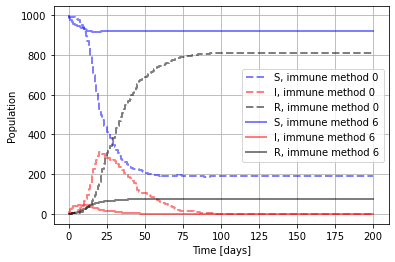

In [63]:
# Plot deterministic and stochastic results in same figure
# i_th_model = 0: Small-world model
# i_th_model = 1: BA model
# intervene_method = 0: No intervene
# intervene_method = 1: Lockdown
# intervene_method = 2: Vaccination
# intervene_method = 3: Selective Vaccine
# intervene_method = 4: Vaccination and Lockdown
# intervene_method = 5: Quarantine
# intervene_method = 6: Vaccination and Quarantine

i_th_model = 1

intervene_method0 = 0
intervene_method1 = 6

fig = plt.figure(facecolor='w')
plt.step(t, Ss_all[intervene_method0, i_th_model], 'b--',  alpha=0.5, lw=2, label='S, immune method {}'.format(intervene_method0))
plt.step(t, Is_all[intervene_method0, i_th_model], 'r--',  alpha=0.5, lw=2, label='I, immune method {}'.format(intervene_method0))
plt.step(t, Rs_all[intervene_method0, i_th_model], 'k--',  alpha=0.5, lw=2, label='R, immune method {}'.format(intervene_method0))

plt.step(t, Ss_all[intervene_method1, i_th_model], 'b',  alpha=0.5, lw=2, label='S, immune method {}'.format(intervene_method1))
plt.step(t, Is_all[intervene_method1, i_th_model], 'r',  alpha=0.5, lw=2, label='I, immune method {}'.format(intervene_method1))
plt.step(t, Rs_all[intervene_method1, i_th_model], 'k',  alpha=0.5, lw=2, label='R, immune method {}'.format(intervene_method1))

plt.xlabel('Time [days]')
plt.ylabel('Population')
plt.grid()
plt.legend()

And we can also print the change of the number of S here.

The first line is without any interference.

The second line is the lockdown.

The third line is randomly vaccine people.

The fourth line is selective vaccine people.

The fifth line is vaccination and lockdown.

The sixth line is quarantine.

The final line is vaccination and quarantine.

In [64]:
print(Ss_all[0:4])
print()
print(Ss_all[4:7])

[[[995. 994. 993. ... 164. 164. 164.]
  [995. 993. 992. ... 189. 189. 189.]]

 [[995. 995. 994. ... 989. 989. 989.]
  [995. 995. 995. ... 896. 896. 896.]]

 [[995. 994. 992. ... 886. 886. 886.]
  [995. 991. 984. ... 560. 560. 560.]]

 [[995. 993. 992. ... 896. 896. 896.]
  [995. 992. 990. ... 589. 589. 589.]]]

[[[995. 994. 994. ... 973. 973. 973.]
  [995. 993. 989. ... 835. 835. 835.]]

 [[995. 995. 994. ... 976. 976. 976.]
  [995. 982. 963. ... 921. 921. 921.]]

 [[995. 994. 991. ... 992. 992. 992.]
  [995. 988. 975. ... 923. 923. 923.]]]


By comparing different interference methods, we notice that vaccine is helpful, especially when you
and your friends do not have large contact with other individuals. But suppose everyone still keeps
the social behavior like before. In that case, the vaccine will not be as helpful as before, especially
when the new variant of COVID appears, making the vaccine’s efficiency drops. For example the
Omicron variant these days.

Combining vaccination and reducing the amount of close contact with other people will dramatically
reduce the number of infected people. But above all of that, the most useful interfere way is still
quarantine people when they show symptoms.

Since this is a small community with 1000 population, the best model to fit the contact of this
community is the BA model, we will give suggestion according to the result in BA model.

So if the community wants to reduce the number of people being infected and the effect of COVID
on society, the best intervention strategy is to quarantine those who show the symptoms of COVID,
and at the same time, give the vaccine to those sensitive people.